# Experimentos e testes

- Este notebook realiza uma série de experimentos, com o intuito de encontrar os melhores parametros para o projeto das Americanas. Para isso foram realizadas algumas etapas de testes:
 - Verificar qual a melhor forma de vetorizar os dados. São testados o Doc2Vec e o TF-IDF.
 - Identificar qual o melhor tipo de pré-processamento textual, são testados a lematização, stemização e lematização+stemização.
 - O dataset possui duas colunas de dados textuais, sendo uma referente ao titulo e outra ao texto da avaliação do cliente. Com isso, são realizados testes para verificar qual coluna melhor representa o sentimento do cliente.
 - É realizada a tecnica de GridSearch para encontrar os melhores parametros para os classificadores.
 - A validação cruzada utilizando o Kfold é utilizada para validar o melhor modelo de classificação. 

- Este notebook foi execultado utilizando a GPU do Google Colaboratory. Isso porque a base de dados é muito grande e os algoritmos são muito pesados para rodar na minha máquina, podendo demorar dias para sua execução. 

- Ademais, este notebook importa do google drive um dataset que já foi pré-processado anteriormente utilizando o notebook de nome "text_processing.ipynb" que está na pasta de notebooks. 

### Google Colab

A celula abaixo só deve ser executada se o notebook estiver rodando no Google Colab. Os códigos abaixo são necessários para possibilitar a execução deste notebook no colab.

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!python3 -m spacy download pt_core_news_sm
!pip install gensim==4.2.0

2023-02-28 16:34:10.798264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 16:34:12.168172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 16:34:12.168309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 16:34:12.168334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
#Para acessar as imagens do Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict,StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,cohen_kappa_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
#from gensim.models import Word2Vec, Doc2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from IPython.display import Markdown
from sklearn.naive_bayes import BernoulliNB
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from IPython.display import Markdown
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt

Carrega o dataset já pré-processado do drive.

In [84]:
df = pd.read_csv(r"drive/My Drive/stefane/neoway/dataset/B2W-Reviews01_edit.csv")
display(df.sample(5))

,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,recommend_to_a_friend_cat,text_stem,text_lemma,text_lemma_stem,title_stem,title_lemma,title_lemma_stem
22115,22115,22115,23591,23591,2018-01-18 13:22:52,2f115443cb32ae87c90bfd6a4b4a540c6a685b624e2d81...,26164187,Casa Casinha De Boneca Polly Com 27 Mini Móvei...,NaN,Brinquedos,Bonecas,gostei muito,5,Yes,"O produto é igual ao que foi anunciado, e cheg...",1982,F,RS,1,"['produt', 'igual', 'anunci', 'cheg', 'quas', ...","['produto', 'igual', 'anunciar', 'chegar', 'qu...","['produt', 'igual', 'anunci', 'cheg', 'quas', ...",['gost'],['gostar'],['gost']
27310,27310,27310,29089,29089,2018-01-24 06:38:11,3cd184cdc8e8f02622aefa14a1970e7e35fdbfc1d6e710...,113174007,Secador Infinity 2500 SC-12 Preto / Vermelho ...,mondial,Beleza e Perfumaria,Aparelhos elétricos para cabelo,PRODUTO DE BOA QUALIDADE,4,Yes,GOSTEI MUITO DO PRODUTO! CHEGOU TUDO CERTINHO ...,1983,F,DF,1,"['gost', 'produt', 'cheg', 'tud', 'cert', 'pou...","['gostar', 'produto', 'chegar', 'tudo', 'certi...","['gost', 'produt', 'cheg', 'tud', 'cert', 'pou...","['produt', 'boa', 'qual']","['produto', 'bom', 'qualidade']","['produt', 'bom', 'qual']"
35706,35706,35706,38050,38050,2018-02-08 17:44:28,04af1cd6f620a471d8add3993163dda2cef20d4c216c95...,9640569,Relógio Invicta Masculino 0072 Pro Diver 48mm ...,NaN,Relógios,Relógios,pergunta,3,No,queria saber se este produto tem garantia ? po...,1999,M,BA,0,"['quer', 'sab', 'produt', 'garant', 'poi', 'qu...","['querer', 'saber', 'produto', 'garantia', 'po...","['quer', 'sab', 'produt', 'garant', 'poi', 'qu...",['pergunt'],['perguntar'],['pergunt']
395,395,395,416,416,2018-01-01 13:26:25,686dfea5aa6771e050183897d232cae74a93bb50b3ff78...,125215742,Liquidificador Philco PH900 2L 12 Velocidades ...,philco,Eletroportáteis,Liquidificador e Acessórios,Nota 1.000,5,Yes,Amei lindo e muito bom recomendo a entrega foi...,1967,F,SP,1,"['ame', 'lind', 'bom', 'recom', 'entreg', 'rap...","['ameir', 'lir', 'bom', 'recomendar', 'entrega...","['ame', 'lir', 'bom', 'recomend', 'entreg', 'r...",['not'],['nota'],['not']
37912,37912,37912,40431,40431,2018-02-19 10:02:22,650033cd3a79235565c5e84c68571c4e5f622e7d50fd04...,27505060,Sofá 4 Lugares Portinari Retrátil e Reclinável...,NaN,Móveis,Sofá,Muito satisfeita!,5,Yes,"Sofá excelente ótimo acabamento, muito macio,...",1986,F,SP,1,"['sof', 'excel', 'ótim', 'acab', 'maci', 'conf...","['sofá', 'excelente', 'bom', 'acabamento', 'ma...","['sof', 'excel', 'bom', 'acab', 'maci', 'confo...",['satisfeit'],['satisfeita'],['satisfeit']


## Vetorização com tfidf
 - Realiza a vetorização utilizando o TF-IDF.
 - Testa a normalização dos dados utilizando o StandartScaler
 - Para testes iniciais é utilizada a coluna 'text_stem' do dataset. Esta coluna tem dados textuais pré-processados utilizando stemização.
 - Os dados são divididos em treino e teste, sempre com o random_state = 42, para que sejam sempre divididos da mesma forma.
 - Os dados são divididos em 80% para treinamento e 20% para teste.

In [71]:
data = df.copy()
data['text_stem'] = data['text_stem'].apply(eval)
X = data['text_stem']
y = data['recommend_to_a_friend_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

Função para o TF-IDF

In [6]:
def vetorizer_tfidf(X_train,X_test):
    """Utiliza o TF-IDF para vetorizar um texto, calculando a frequencia das palavras em um texto

    Args:
        X_train (array): Uma lista contendo os dados para treinamento.
        X_test (array): Uma lista contendo os dados para teste.

    Returns:
        X_train (array): Dataset de treinamento vetorizado com o TF-IDF
        X_test (array): Dataset de teste vetorizado com o TF-IDF
    """
    vetorizer = CountVectorizer()
    X_train = vetorizer.fit_transform(X_train.map(' '.join))
    X_test = vetorizer.transform(X_test.map(' '.join))

    transformer = TfidfTransformer()
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)

    return X_train, X_test

Função para a normalização

In [7]:
def scaler(X_train,X_test):
    """Utiliza o StandardScaler para normalizar os dados.

    Args:
        X_train (array): Uma lista contendo os dados para treinamento.
        X_test (array): Uma lista contendo os dados para teste.

    Returns:
        X_train (array): Dataset de treinamento normalizados.
        X_test (array): Dataset de teste normalizados.
    """
    scaler = StandardScaler(with_mean=False).fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

Função para plotar a matriz de confusão

In [8]:
def matrix(matrix):
    """Plota uma matriz de confusão

    Args:
        matrix (array): Um Array referente a uma matriz de confusão de 2x2
    """
    plt.figure(figsize=(5,5))
    fig, ax = plt.subplots()
    sns.heatmap(matrix, annot=True, fmt="", cmap="Blues")
    ax.set_xticklabels(['Ruim', 'Bom'])
    ax.set_yticklabels(['Ruim', 'Bom'])
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Reviews")

Dois testes são realizados, sendo eles:
- Utilizando apenas o TF-IDF
- Utilizando o TF-IDF + normalização

###Acurácia utilizando LogisticRegression e TFIDF: 90.19%

<Figure size 360x360 with 0 Axes>

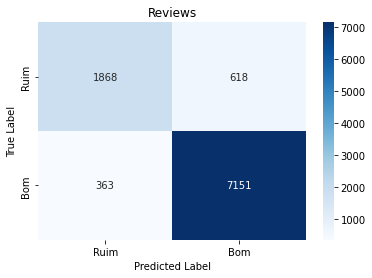

In [9]:
#Vetoriza com o TF-IDF
X_train_tfidf, X_test_tfidf = vetorizer_tfidf(X_train,X_test)

#Treina o classificador
model_LR = LogisticRegression(solver='lbfgs', max_iter=500,random_state=42)
model_LR = model_LR.fit(X_train_tfidf, y_train)

#Plota os resultados
pred_LR = model_LR.predict(X_test_tfidf)
acc = accuracy_score(y_test,pred_LR) * 100
display(Markdown(f"###Acurácia utilizando LogisticRegression e TFIDF: {acc}%"))
matrix(confusion_matrix(y_test, pred_LR))

###Acurácia utilizando LogisticRegression e TFIDF + normalização: 85.8%

<Figure size 360x360 with 0 Axes>

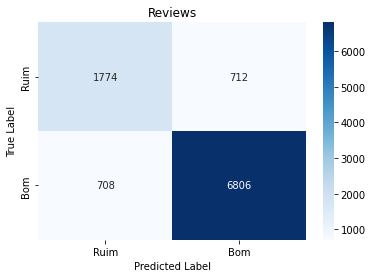

In [10]:
#Vetoriza e normaliza
X_train_tfidf, X_test_tfidf = vetorizer_tfidf(X_train,X_test)
X_train_tfidf, X_test_tfidf = scaler(X_train_tfidf, X_test_tfidf)

#Treina o classificador
model_LR = LogisticRegression(solver='lbfgs', max_iter=500,random_state=42)
model_LR = model_LR.fit(X_train_tfidf, y_train)

#Plota os resultados
pred_LR = model_LR.predict(X_test_tfidf)
acc = accuracy_score(y_test,pred_LR) * 100
display(Markdown(f"###Acurácia utilizando LogisticRegression e TFIDF + normalização: {acc}%"))
matrix(confusion_matrix(y_test, pred_LR))

Após esta analise fica claro que é mais eficiente utilizar apenas o TF-IDF sem a normalização.

## Vetorização com Doc2Vec
- Utiliza o Doc2Vec para vetorizar as frases.
- Salva o modelo em um path especifico.

Função para o CallBack do Doc2vec.

In [11]:
class Loss(CallbackAny2Vec):
    """Utilizada para fazer o callback do Doc2vec

    Args:
        CallbackAny2Vec (callbacks)
    """
    def __init__(self, num_epochs):
        """Metodo construtor da classe Loss

        Args:
            num_epochs (int): Número de epocas para treinamento do modelo
        """
        self.verbose = tqdm(range(num_epochs), desc='Training Doc2Vec')
        self.epoch = 1
        self.loss = []
        self.loss_prev_step = None

    def on_epoch_end(self, model):
        """ Imprime o verbose

        Args:
            model (doc2vec): Modelo de treinamento do Doc2vec
        """
        if self.epoch == 1:
            current_loss = model.get_latest_training_loss()
        else:
            current_loss = model.get_latest_training_loss() - self.loss_previous_step
        
        self.loss.append(current_loss)
        self.loss_previous_step = model.get_latest_training_loss()
        self.epoch += 1

        self.verbose.set_postfix(loss=current_loss)
        self.verbose.update(1)


Função para treinamento do modelo Doc2Vec.

In [12]:
def fit_doc2vec(texts,embedding_size, num_iter=int(5e+3)):
    """Treina o modelo Doc2Vec

    Args:
        texts (array): Dataset textual para treinamento.
        embedding_size (int): Tamanho do embedding.
        num_iter (int, optional): Numero de epocas para treinamento do modelo. Defaults to int(5e+3).

    Returns:
        doc2vec: Modelo Doc2Vec treinado.
    """
    texts = [TaggedDocument(text, tags=[i]) for i,text in enumerate(texts)]
    loss = Loss(num_iter)
    model = Doc2Vec(
        vector_size=embedding_size,
        window=5,
        min_count=1,
        min_alpha=1e-4,
        epochs=num_iter,
        callbacks=[loss]
    )
    model.build_vocab(texts)
    model.train(texts, total_examples=model.corpus_count, epochs=model.epochs,callbacks = [loss] )
    return model

Treina e salva o modelo do doc2vec

In [16]:
path_model = r"drive/My Drive/stefane/neoway/dataset/d2v.model"
model = fit_doc2vec(X_train,128, num_iter=3000)
model.save(path_model)

Vetoriza utilizando o doc2vec

In [17]:
model = Doc2Vec.load(path_model)
X_train = [model.infer_vector(doc) for doc in X_train]
X_test = [model.infer_vector(doc) for doc in X_test]

Treina um classificador e calcula a acucácia

###Acurácia utilizando LogisticRegression e Doc2Vec: 85.8%

<Figure size 360x360 with 0 Axes>

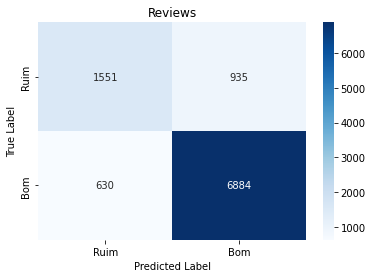

In [18]:
#Treina o classificador
model_LR = LogisticRegression(solver='lbfgs', max_iter=500,random_state=42)
model_LR = model_LR.fit(X_train, y_train)
pred_LR = model_LR.predict(X_test)

##Plota os resultados
display(Markdown(f"###Acurácia utilizando LogisticRegression e Doc2Vec: {acc}%"))
matrix(confusion_matrix(y_test, pred_LR))

## GridSearch
- É utilizado para encontrar os melhores parametros para os classificadores

Divide os dados em treino e teste e vetoriza utilizando tf-idf

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)
X_train, X_test = vetorizer_tfidf(X_train,X_test)

Define os parametros que devem ser testados pelo GridSearch

In [82]:
params = []
check_parameters_lr = {"C": np.logspace(-3,3,7), "penalty": ["l1","l2"]}

check_parameters_rf = {'n_estimators': [200, 500],
  'max_features': ['sqrt', 'log2'],
  'max_depth' : [4, 5, 6, 7, 8],
  'criterion' :['gini', 'entropy'],
  'min_samples_split': [2, 5, 10]
}
check_parameters_nb = {'fit_prior': [True, False],
  'class_prior': [None, [0.1,] * 2, ]
}
check_parameters_knn = {"n_neighbors": list(np.arange(3, 20, 2))}

params.append(check_parameters_lr)
params.append(check_parameters_nb)
params.append(check_parameters_knn)
params.append(check_parameters_rf)

classifiers = [LogisticRegression(max_iter=3000, solver='liblinear', multi_class='ovr',random_state=12345), 
                BernoulliNB(),
                KNeighborsClassifier(),
                RandomForestClassifier(random_state=12345),
               ]

Utiliza o GridSearch para encontrar os melhores parametros para os classificadores.

In [83]:
for index, classifier in enumerate(classifiers):
    display(Markdown(f"### {classifier.__class__.__name__}"))
    grid_search_cv = GridSearchCV(classifier, params[index], n_jobs=-1, cv=5)
    grid_search_cv.fit(X_train, y_train.ravel())
    display(Markdown(f'\n- Best parameters found - {classifier.__class__.__name__}: {grid_search_cv.best_params_}'))

    y_predict = grid_search_cv.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    f1 = f1_score(list(y_test), list(y_predict), average='macro')
    precision = precision_score(list(y_test), list(y_predict), average='macro')
    recall = recall_score(list(y_test), list(y_predict), average='macro')
    display(Markdown(f'\n- Acc: {acc*100}\n- F1 Score: {f1*100}\n- Precision: {precision*100}\n- Recall: {recall*100}\n'))

### LogisticRegression


- Best parameters found - LogisticRegression: {'C': 1.0, 'penalty': 'l2'}


- Acc: 90.2
- F1 Score: 86.4078567248294
- Precision: 87.89685835465046
- Recall: 85.17501575498329


### BernoulliNB


- Best parameters found - BernoulliNB: {'class_prior': None, 'fit_prior': False}


- Acc: 86.03
- F1 Score: 81.2856942394567
- Precision: 81.31531831887256
- Recall: 81.25623266710934


### KNeighborsClassifier


- Best parameters found - KNeighborsClassifier: {'n_neighbors': 3}


- Acc: 77.10000000000001
- F1 Score: 52.45016611295681
- Precision: 79.0884736128446
- Recall: 54.736120357579765


### RandomForestClassifier


- Best parameters found - RandomForestClassifier: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


- Acc: 75.32
- F1 Score: 43.74279460995794
- Precision: 83.09735964576615
- Recall: 50.38894412382485


## Validação Cruzada 
- A validação cruzada é utilizada para escolher o melhor modelo.
- É utilizado o algoritmo StratifiedKFold com k igual a 10

Define os classificadores que serão utilizados na validação cruzada.

In [23]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=3000, 
                                              solver='liblinear',
                                              multi_class='ovr',
                                              random_state=12345),
    'BernoulliNB': BernoulliNB(),
    'KNN': KNeighborsClassifier(n_neighbors= 3),
    'Random Forest': RandomForestClassifier(criterion= 'gini', 
                                            max_depth= 8, 
                                            max_features= 'sqrt', 
                                            min_samples_split= 2, 
                                            n_estimators= 200,
                                            random_state=12345),
               
    'Bagging Classifier': BaggingClassifier(LogisticRegression(max_iter=3000, 
                                              solver='liblinear',
                                              multi_class='ovr',
                                              random_state=12345))
                    
}

Função para treinar um modelo e retornar o resultado das métricas de validação.

In [24]:
def train_models(X_train,X_test,y_train,y_test,model,name_model):
    """Treina um classificador e calcula as métricas: acurácia, precisão, recall, f1-score, e gera a matriz de confusão.

    Args:
        X_train (Array): Dados para treinamento
        X_test (Array): Dados de teste
        y_train (Array): Rótulos de treinamento
        y_test (Array): Rótulos de teste
        model (Sklearn Model): Classificador
        name_model (String): Nome do classificador

    Returns:
        dict: Retorna um dicionário com as informações: 
            Name Model, Precision, Recall, F1-Score, Accuracy, Confusion Matrix e o modelo treinado
    """
    model.fit(X_train, y_train)    
    predictions = model.predict(X_test)
    
    #Calcula as metricas do modelo
    acc = accuracy_score(y_test, predictions) * 100
    precision = precision_score(y_test, predictions) * 100
    recall = recall_score(y_test, predictions) * 100
    f1 = f1_score(y_test, predictions) * 100
    conf_mat = confusion_matrix(y_test, predictions)
    metrics = {
        'Name Model':name_model,
        'Precision':precision,
        'Recall': recall,
        'F1-score': f1,
        'Accuracy': acc,
        'Confusion matrix':conf_mat,
        'Model': model
    }
    return metrics

Dados e rotulados para serem utilizados na validação cruzada

In [25]:
X = df['text_stem']
y = df['recommend_to_a_friend_cat']

Código para validação cruzada.

In [26]:
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
dataset_results = []
for train_index, test_index in kf.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  X_train, X_test = vetorizer_tfidf(X_train,X_test)

  for model in classifiers:
    metrics = train_models(X_train, X_test,y_train, y_test, classifiers[model], model)
    dataset_results.extend([metrics])

#dataset com os resultados
dataset_results = pd.DataFrame(dataset_results)
dataset_results

,Name Model,Precision,Recall,F1-score,Accuracy,Confusion matrix,Model
0,Logistic Regression,92.721601,94.917509,93.806706,90.58,"[[962, 280], [191, 3567]]","LogisticRegression(max_iter=3000, multi_class=..."
1,BernoulliNB,89.456045,92.336349,90.873380,86.06,"[[833, 409], [288, 3470]]",BernoulliNB()
...,...,...,...,...,...,...,...
48,Random Forest,75.240385,99.973383,85.861241,75.26,"[[7, 1236], [1, 3756]]","(DecisionTreeClassifier(max_depth=8, max_featu..."
49,Bagging Classifier,91.923077,95.421879,93.639807,90.26,"[[928, 315], [172, 3585]]","(LogisticRegression(max_iter=3000, multi_class..."


Função para printar o resultado da validação cruzada

In [27]:
def metrics(data,name_model,metric):
  metric_mean = data[data['Name Model']==name_model][metric].mean()
  metric_std = data[data['Name Model']==name_model][metric].std()
  max = data[data['Name Model']==name_model][metric].max()
  display(Markdown(f'\n- {metric}: {metric_mean:.2f} +- {metric_std:.2f}\n- Maior {metric}: {max:.2f}'))

In [28]:
for model in classifiers:
  display(Markdown(f'###{model}'))
  metrics(dataset_results,model,'Accuracy')
  metrics(dataset_results,model,'F1-score')

###Logistic Regression


- Accuracy: 90.32 +- 0.43
- Maior Accuracy: 90.80


- F1-score: 93.65 +- 0.29
- Maior F1-score: 93.97

###BernoulliNB


- Accuracy: 86.12 +- 0.52
- Maior Accuracy: 86.72


- F1-score: 90.90 +- 0.36
- Maior F1-score: 91.28

###KNN


- Accuracy: 75.02 +- 6.00
- Maior Accuracy: 78.18


- F1-score: 83.38 +- 7.45
- Maior F1-score: 87.03

###Random Forest


- Accuracy: 75.31 +- 0.06
- Maior Accuracy: 75.46


- F1-score: 85.89 +- 0.03
- Maior F1-score: 85.96

###Bagging Classifier


- Accuracy: 90.25 +- 0.36
- Maior Accuracy: 90.76


- F1-score: 93.61 +- 0.25
- Maior F1-score: 93.95

A partir desta analise, fica claro que o classificador de Regressão logistica possui os melhores resultados de classificação, tendo uma média de acurácia de 90.32% e do F1-Score de 93.65%. Logo este classificador deve ser utilizado como padrão para o projeto.

## Experimento do com os pré-processamentos
- Este experimento foi desenvolvido para encontrar a melhor técnica de pré-processamento e quais colunas do dataset melhor representam o sentimento dos usuários.
- Os experimentos são:
  - Teste com os pré-processamentos de lematização, stematização e lematização + stemização.
  - Teste utilizando a coluna de title, text e title + text.

In [85]:
data = df.copy()
data['text_stem'] = data['text_stem'].apply(eval)
data['title_stem'] = data['title_stem'].apply(eval)
data['title_text_stem'] = [title+text for title, text in zip(data['title_stem'],data['text_stem'])]

data['text_lemma'] = data['text_lemma'].apply(eval)
data['title_lemma'] = data['title_lemma'].apply(eval)
data['title_text_lemma'] = [title+text for title, text in zip(data['title_lemma'],data['text_lemma'])]

data['text_lemma_stem'] = data['text_lemma_stem'].apply(eval)
data['title_lemma_stem'] = data['title_lemma_stem'].apply(eval)
data['title_text_lemma_stem'] = [title+text for title, text in zip(data['title_lemma_stem'],data['text_lemma_stem'])]

In [86]:
y = data['recommend_to_a_friend_cat']
data = data[['text_stem',
       'text_lemma', 
       'text_lemma_stem', 
       'title_stem', 
       'title_lemma',
       'title_lemma_stem', 
       'title_text_stem', 
       'title_text_lemma',
       'title_text_lemma_stem']]

In [87]:
display(Markdown(f"###Acurácias"))
for col in data.columns:
  X = data[col]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

  X_train_tfidf, X_test_tfidf = vetorizer_tfidf(X_train,X_test)

  #Treina o classificador
  model_LR = LogisticRegression(solver='lbfgs', multi_class='ovr',max_iter=3000,random_state=12345)
  model_LR = model_LR.fit(X_train_tfidf, y_train)

  #Plota os resultados
  pred_LR = model_LR.predict(X_test_tfidf)
  acc = accuracy_score(y_test,pred_LR) * 100
  display(Markdown(f"\n- {col}: {acc:.2f}%"))

###Acurácias


- text_stem: 90.19%


- text_lemma: 90.21%


- text_lemma_stem: 89.93%


- title_stem: 88.79%


- title_lemma: 89.05%


- title_lemma_stem: 88.78%


- title_text_stem: 91.96%


- title_text_lemma: 92.49%


- title_text_lemma_stem: 92.17%

A Partir desta analíse, fica claro que a lematização é o melhor pré-processamento textual para os dados das Americanas, onde alcançou 92.49% de acurácia utilizando a coluna com os dados de title e text. Sendo assim, ela será utilizada como pré-processamento padrão. 